In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import minimize
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import entropy

In [19]:
# Load COSMIC mutsig data
df_sig = pd.read_csv("COSMIC_v3.3.1_SBS_GRCh37.txt", sep="\t")

# Variables and contributions dictionary
variants = 100
num_data = 50
base_contributions = {
    "SBS1": 25,
    "SBS18": 8,
    "SBS32": 4,
    "SBS37": 4,
    "SBS39": 3
}

Helper functions

In [20]:
# Original generate_data function
def generate_data(num_variants, num_sets, contributions, ref_sigs):
    # datasets list
    datasets = []
    for n in range(num_sets):
        coeffs = {}
        for s_ in contributions:
            coeffs[s_] = contributions[s_]
        total = sum(coeffs.values())
        # build die
        weights = np.zeros(96)
        for s_ in coeffs:
            c_ = coeffs[s_] / total
            weights += c_ * ref_sigs[s_].values
        # build data
        data = np.random.choice(np.arange(96), size=num_variants, replace=True, p=weights)
        # store dataset in list
        data_dic = {
            "substitution": df_sig['Type'].values,
            "frequency": [np.count_nonzero(data == i) for i in range(96)]
        }
        dataframe = pd.DataFrame(data_dic)
        # Calculate 'p' column
        dataframe['p'] = dataframe['frequency'] / dataframe['frequency'].sum()
        datasets.append(dataframe)
    return datasets

def objective_function_l2(c, m, S):
    return np.linalg.norm(m - np.dot(c, S), ord=2)

def fit_signatures(sample, ref, cost_fn):
    S = ref.select_dtypes(include=np.number)
    n_sigs = len(S.columns)
    S = np.array(S.values.tolist())
    m = sample['p'].to_numpy()
    c0 = np.ones((n_sigs, )) / n_sigs
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    bounds = [(0, 1) for i in range(n_sigs)]
    result = minimize(cost_fn, c0, args=(m, S.T), method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def get_contributions(res, ref):
    columns = ref.select_dtypes(include=np.number).columns    
    contri = pd.DataFrame({'Signatures' : columns, 'Contribution' : res.x.tolist()})
    contri = contri.sort_values(by = ['Contribution'], ascending = False, ignore_index=True)
    return contri

def optimized_get_cosine_sim(samples, ref, cost_fn):
    cosine_sim_values = []
    count = len(samples)
    signatures = ref.select_dtypes(include=np.number).columns.to_list()
    for i in range(count):
        res = fit_signatures(samples[i], ref, cost_fn)
        contri = get_contributions(res, ref)
        calc_contribution = np.zeros(96,)
        for j in range(len(contri)):
            calc_contribution += ref[contri['Signatures'][j]].to_numpy() * contri['Contribution'][j]
        original_p = samples[i]['p'].to_numpy().reshape(1, -1)
        cosine_sim = cosine_similarity(calc_contribution.reshape(1, -1), original_p)[0][0]
        cosine_sim_values.append(cosine_sim)
    return cosine_sim_values

def calculate_entropy(sample):
    return entropy(sample['p'], base=2)
    
def get_peakiness(sample):
    return 1 / calculate_entropy(sample)

def gather_data_for_variants_range_with_std_cosine(start, end, interval, contributions, df_sig, ref, cost_fn):
    variant_counts = list(range(start, end + 1, interval))
    cosine_sim_values_avg = []
    cosine_sim_std_values = []
    
    for count in variant_counts:
        samples = generate_data(count, num_data, contributions, df_sig)
        cosine_sim_values = optimized_get_cosine_sim(samples, ref, cost_fn)
        cosine_sim_values_avg.append(np.mean(cosine_sim_values))
        cosine_sim_std_values.append(np.std(cosine_sim_values))
    
    return variant_counts, cosine_sim_values_avg, cosine_sim_std_values

def plot_variants_vs_cosine_sim_with_errorbars(variant_counts, cosine_sim_values, cosine_sim_std_values):
    plt.figure(figsize=(10, 6))
    plt.errorbar(variant_counts, cosine_sim_values, yerr=cosine_sim_std_values, color='black', ecolor='red', 
                 fmt='o', capsize=5, alpha=0.7)
    plt.title("Mean Cosine Similarity vs Frequency of Variants (with Error Bars)")
    plt.xlabel("Specified Total Frequency of Variants")
    plt.ylabel("Average Cosine Similarity")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Optimized function for cosine similarity calculation
def optimized_get_cosine_sim(samples, ref, cost_fn):
    cosine_sim_values = []
    count = len(samples)
    signatures = ref.select_dtypes(include=np.number).columns.to_list()
    for i in range(count):
        res = fit_signatures(samples[i], ref, cost_fn)
        contri = get_contributions(res, ref)
        calc_contribution = np.zeros(96,)
        for j in range(len(contri)):
            calc_contribution += ref[contri['Signatures'][j]].to_numpy() * contri['Contribution'][j]
        original_p = samples[i]['p'].to_numpy().reshape(1, -1)
        cosine_sim = cosine_similarity(calc_contribution.reshape(1, -1), original_p)[0][0]
        cosine_sim_values.append(cosine_sim)
    return cosine_sim_values

# Function to generate data with varying peakiness
def generate_peakiness_contributions(base_contributions, steps=100, step_size=1):  # Modified step_size parameter
    """
    Gradually change the contributions dictionary to generate different levels of peakiness in the samples.
    Returns a list of varied contributions configurations.
    """
    varied_contributions = []
    for i in range(steps):
        temp_contrib = {}
        for key, value in base_contributions.items():
            temp_contrib[key] = value + i * step_size
        varied_contributions.append(temp_contrib)
    return varied_contributions

def gather_data_peakiness_vs_accuracy_with_std(base_contributions, df_sig, ref, cost_fn, num_samples_per_config=10):
    varied_contributions_list = generate_peakiness_contributions(base_contributions)
    peakiness_values = []
    cosine_sim_avg_values = []
    cosine_sim_std_values = []
    
    for contributions in varied_contributions_list:
        temp_cosine_sims = []
        for _ in range(num_samples_per_config):
            sample = generate_data(variants, 1, contributions, df_sig)[0]
            peakiness = get_peakiness(sample)
            cosine_sim = optimized_get_cosine_sim([sample], ref, cost_fn)[0]
            temp_cosine_sims.append(cosine_sim)
        peakiness_values.append(peakiness)
        cosine_sim_avg_values.append(np.mean(temp_cosine_sims))
        cosine_sim_std_values.append(np.std(temp_cosine_sims))
    return peakiness_values, cosine_sim_avg_values, cosine_sim_std_values

# Function to plot the relationship with error bars
def plot_peakiness_vs_accuracy_with_errorbars(entropy_vals, cosine_sim_avg_vals, cosine_sim_std_vals):
    plt.figure(figsize=(10, 6))
    plt.errorbar(entropy_vals, cosine_sim_avg_vals, yerr=cosine_sim_std_vals, fmt='o', capsize=5, alpha=0.7, label='Data Points')
    plt.title("Accuracy (Average Cosine Similarity) vs Peakiness (Entropy)")
    plt.xlabel("Entropy (Peakiness)")
    plt.ylabel("Average Cosine Similarity (Accuracy)")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [21]:
# Merging and preparing reference signatures
merged_df = pd.merge(generate_data(variants, 1, base_contributions, df_sig)[0], df_sig, left_on='substitution', right_on='Type')  
ref_sig = merged_df.drop(columns=['substitution', 'frequency', 'p'])

# Gathering the data for cosine similarity with standard deviations and plotting the scatter graph with error bars
peakiness_vals, cosine_sim_avg_vals, cosine_sim_std_vals = gather_data_peakiness_vs_accuracy_with_std(base_contributions, df_sig, ref_sig, objective_function_l2)

Scatterplot of cosine similarity vs peakiness (with lm line)

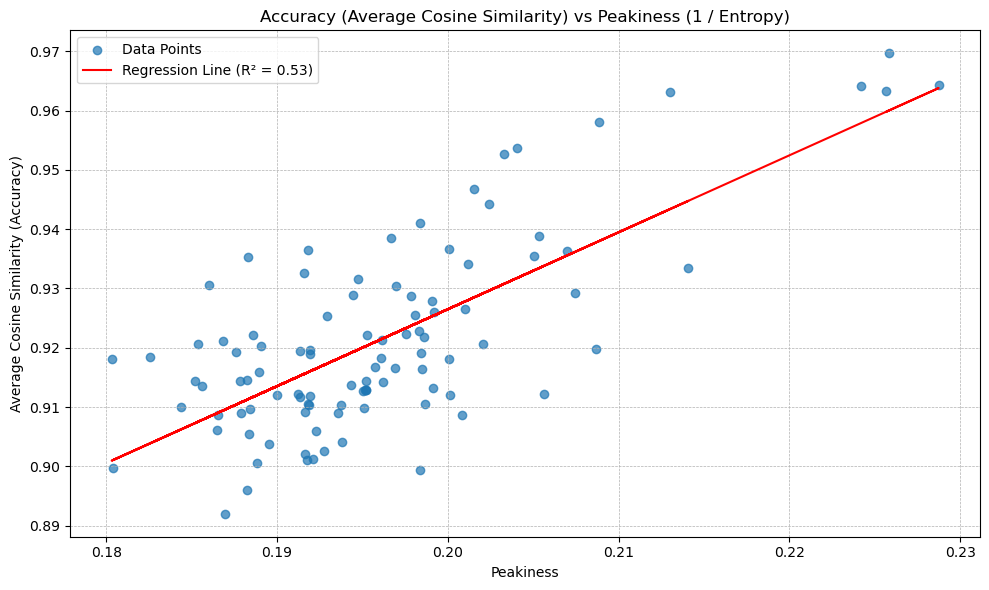

In [22]:
# Fit a linear regression model
slope, intercept, r_value, p_value, std_err = linregress(peakiness_vals, cosine_sim_avg_vals)

# Generate y values based on the regression model
regression_y = [slope*x + intercept for x in peakiness_vals]


# Plot
plt.figure(figsize=(10, 6))
plt.scatter(peakiness_vals, cosine_sim_avg_vals, alpha=0.7, label='Data Points')
plt.plot(peakiness_vals, regression_y, color='red', label=f'Regression Line (R² = {r_value**2:.2f})')
plt.title("Accuracy (Average Cosine Similarity) vs Peakiness (1 / Entropy)")
plt.xlabel("Peakiness")
plt.ylabel("Average Cosine Similarity (Accuracy)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Scatterplot of cosine similarity vs peakiness (with lowess curve)

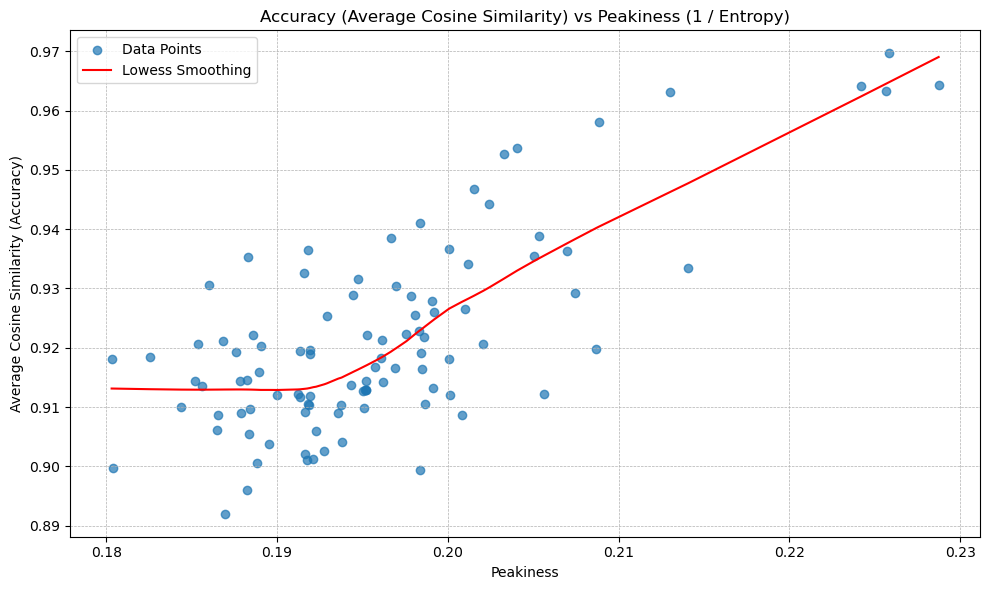

In [23]:
from statsmodels.nonparametric.smoothers_lowess import lowess


# Use lowess to get a smoothed line
smoothed = lowess(cosine_sim_avg_vals, peakiness_vals)  # The frac parameter controls the degree of smoothing

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(peakiness_vals, cosine_sim_avg_vals, alpha=0.7, label='Data Points')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label='Lowess Smoothing')
plt.title("Accuracy (Average Cosine Similarity) vs Peakiness (1 / Entropy)")
plt.xlabel("Peakiness")
plt.ylabel("Average Cosine Similarity (Accuracy)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

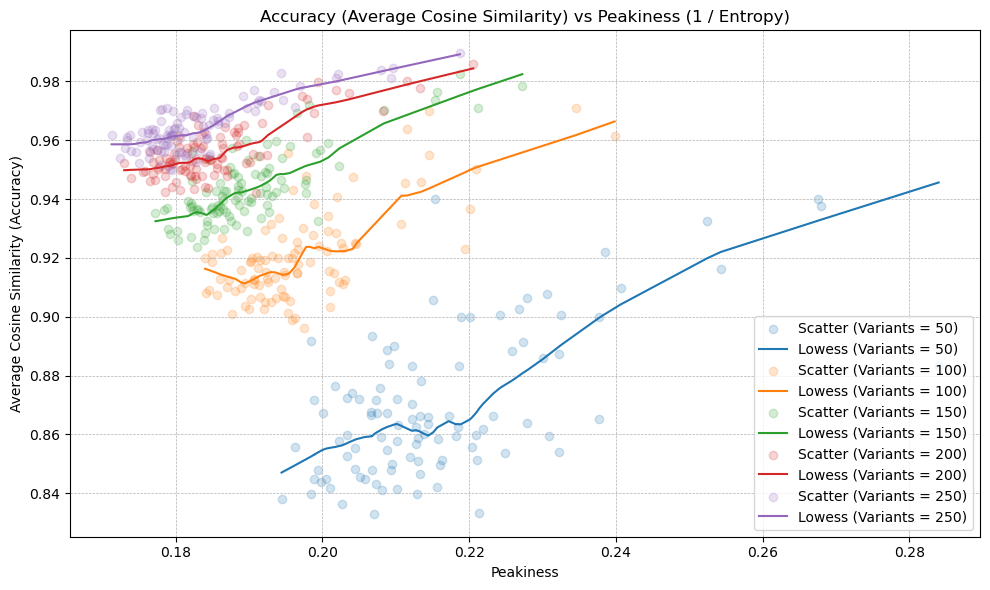

In [24]:
# Set up the plot
plt.figure(figsize=(10, 6))

# Loop over variants from 50 to 250 in intervals of 50
for variants in range(50, 251, 50):
    # Generate and process the data
    peakiness_vals, cosine_sim_avg_vals, _ = gather_data_peakiness_vs_accuracy_with_std(base_contributions, df_sig, ref_sig, objective_function_l2)
    
    # Add scatter plot with reduced opacity
    plt.scatter(peakiness_vals, cosine_sim_avg_vals, alpha=0.2, label=f'Scatter (Variants = {variants})')
    
    # Compute the lowess smoothed curve
    z = lowess(cosine_sim_avg_vals, peakiness_vals, frac=0.3)
    
    # Plot the smoothed curve for the current number of variants
    plt.plot(z[:, 0], z[:, 1], label=f'Lowess (Variants = {variants})')

# Set plot details and display
plt.title("Accuracy (Average Cosine Similarity) vs Peakiness (1 / Entropy)")
plt.xlabel("Peakiness")
plt.ylabel("Average Cosine Similarity (Accuracy)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

with Confidence intervals

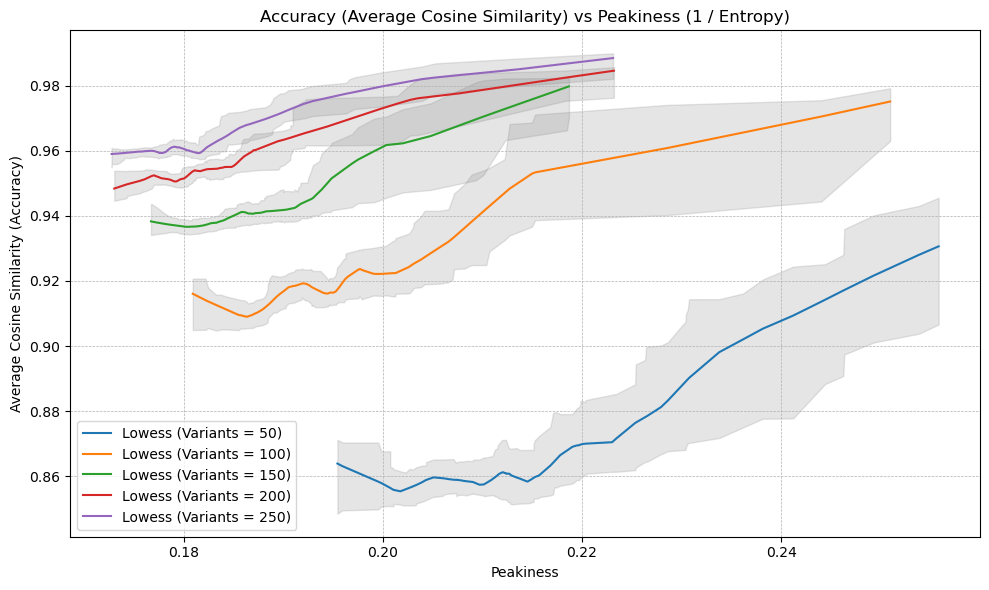

In [25]:
def bootstrap_lowess(x, y, frac=0.3, it=100, alpha=0.95):
    bootstrapped = []
    
    # Convert x and y to numpy arrays for indexing
    x = np.array(x)
    y = np.array(y)
    
    for _ in range(it):
        indices = np.random.choice(len(x), len(x), replace=True)
        bootstrapped.append(lowess(y[indices], x[indices], frac=frac)[:, 1])
    
    bootstrapped = np.array(bootstrapped)
    lower = np.percentile(bootstrapped, (1.0 - alpha) / 2.0 * 100, axis=0)
    upper = np.percentile(bootstrapped, (1.0 + alpha) / 2.0 * 100, axis=0)
    
    return lower, upper

# Set up the plot
plt.figure(figsize=(10, 6))

# Loop over variants from 50 to 250 in intervals of 50
for variants in range(50, 251, 50):
    # Generate and process the data
    peakiness_vals, cosine_sim_avg_vals, _ = gather_data_peakiness_vs_accuracy_with_std(base_contributions, df_sig, ref_sig, objective_function_l2)
    
    # Compute the lowess smoothed curve
    z = lowess(cosine_sim_avg_vals, peakiness_vals, frac=0.3)
    
    # Bootstrap to get the confidence intervals
    lower, upper = bootstrap_lowess(peakiness_vals, cosine_sim_avg_vals)
    
    # Plot the smoothed curve and the confidence intervals
    plt.plot(z[:, 0], z[:, 1], label=f'Lowess (Variants = {variants})')
    plt.fill_between(z[:, 0], lower, upper, color='gray', alpha=0.2)

# Set plot details and display
plt.title("Accuracy (Average Cosine Similarity) vs Peakiness (1 / Entropy)")
plt.xlabel("Peakiness")
plt.ylabel("Average Cosine Similarity (Accuracy)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [26]:
#Gathering the data for cosine similarity with standard deviations in a range
variant_counts, cosine_sim_avg, cosine_sim_std = gather_data_for_variants_range_with_std_cosine(50, 500, 50, base_contributions, df_sig, ref_sig, objective_function_l2)

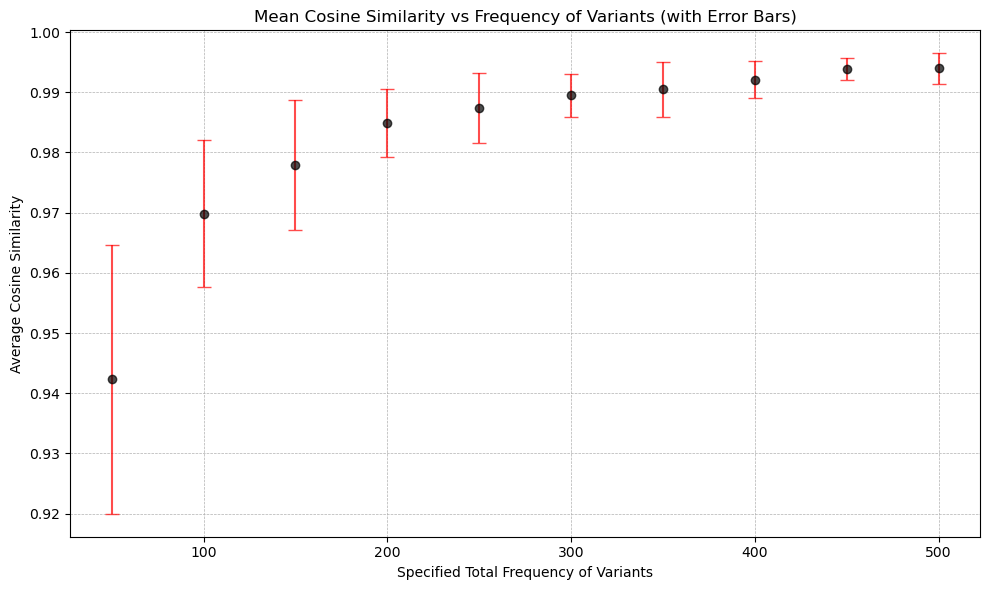

In [27]:
#scatter plot with error bars
plot_variants_vs_cosine_sim_with_errorbars(variant_counts, cosine_sim_avg, cosine_sim_std)

In [29]:
np.save('peakiness_vals.npy', peakiness_vals)

In [ ]:
np.save('peakiness_vals.npy', peakiness_vals)

In [30]:
# Adjusting the parameters for a quicker computation
def generate_peakiness_contributions_reduced(base_contributions, steps=50, step_size=1):
    varied_contributions = []
    for i in range(steps):
        temp_contrib = {}
        for key, value in base_contributions.items():
            temp_contrib[key] = value + i * step_size
        varied_contributions.append(temp_contrib)
    return varied_contributions

def gather_data_peakiness_vs_accuracy_with_std_reduced(base_contributions, df_sig, ref, cost_fn, num_samples_per_config=5):
    varied_contributions_list = generate_peakiness_contributions_reduced(base_contributions)
    peakiness_values = []
    cosine_sim_avg_values = []
    cosine_sim_std_values = []
    
    for contributions in varied_contributions_list:
        temp_cosine_sims = []
        for _ in range(num_samples_per_config):
            sample = generate_data(variants, 1, contributions, df_sig)[0]
            peakiness = get_peakiness(sample)
            cosine_sim = optimized_get_cosine_sim([sample], ref, cost_fn)[0]
            temp_cosine_sims.append(cosine_sim)
        peakiness_values.append(peakiness)
        cosine_sim_avg_values.append(np.mean(temp_cosine_sims))
        cosine_sim_std_values.append(np.std(temp_cosine_sims))
    return peakiness_values, cosine_sim_avg_values, cosine_sim_std_values

# Running the computation for each variant level sequentially
variant_levels = [50, 100, 150, 200, 250]
all_peakiness_vals = {}
all_cosine_sim_avg_vals = {}

for variant in variant_levels:
    variants = variant
    peakiness_vals, cosine_sim_avg_vals, _ = gather_data_peakiness_vs_accuracy_with_std_reduced(base_contributions, df_sig, ref_sig, objective_function_l2)
    all_peakiness_vals[variant] = peakiness_vals
    all_cosine_sim_avg_vals[variant] = cosine_sim_avg_vals

all_peakiness_vals, all_cosine_sim_avg_vals


({50: [0.24081447425616528,
   0.24335192528911107,
   0.2692040915008007,
   0.2241414769426279,
   0.2415836161563491,
   0.21793908043420454,
   0.2346101471752215,
   0.24798587796955873,
   0.21014747785906557,
   0.2268413451715763,
   0.2198780080169366,
   0.2295952568413832,
   0.22517061222188564,
   0.22704708268288934,
   0.24888922661752197,
   0.23168284274515927,
   0.23990207545281708,
   0.21971877674682072,
   0.24210107405107456,
   0.23162057116651277,
   0.20175259940036966,
   0.21260920612547227,
   0.22583679332738768,
   0.22096843501855903,
   0.21205630197953285,
   0.2170906748142913,
   0.20045067567028363,
   0.2165142479053437,
   0.22054717521563472,
   0.21055845052376662,
   0.21305332151447726,
   0.21745923957653088,
   0.20207088549148605,
   0.20914079631092014,
   0.21046993731313623,
   0.24979405325526144,
   0.20707041644095708,
   0.22979055221912742,
   0.2210660008030676,
   0.23048730802712547,
   0.21567687804899058,
   0.21971877674682067

In [31]:
results = []

# Loop over variants from 50 to 250 in intervals of 50
for variants in range(50, 251, 50):
    # Generate and process the data
    peakiness_vals, cosine_sim_avg_vals, _ = gather_data_peakiness_vs_accuracy_with_std(base_contributions, df_sig, ref_sig, objective_function_l2)
    results.append((variants, peakiness_vals, cosine_sim_avg_vals))

TypeError: not all arguments converted during string formatting

In [33]:
# Save the results to a file for later analysis
with open('results.txt', 'w') as f:
    for item in results:
        f.write(repr(item) + "\n")

In [34]:
def plot_sample(df):
    import matplotlib.patches as mpatches
    plt.figure(figsize=(20, 4))

    colors = []
    subs = df['substitution']
    subs = subs.str.extract('\[(.*?)\]', expand=False)    
    
    for substitution in subs:
        if substitution in ['C>A']:
            colors.append('blue')

        elif substitution in ['C>G']:
            colors.append('black')
        
        elif substitution in ['C>T']:
            colors.append('red')
            
        elif substitution in ['T>A']:
            colors.append('grey')
            
        elif substitution in ['T>C']:
            colors.append('green')
            
        else:
            colors.append('pink')
            
    
    plt.bar(df["substitution"], df["frequency"], color = colors, width = 0.6)
    plt.margins(x=0)
    plt.xticks(rotation=90)
    plt.xlabel('Substitution')
    plt.ylabel('Mutation Count')
    plt.title('Mutational substitution analysis', x=0.5, y=1.1)
    blue_patch = mpatches.Patch(color='blue', label='C>A')
    black_patch = mpatches.Patch(color='black', label='C>G')
    red_patch = mpatches.Patch(color='red', label='C>T')
    grey_patch = mpatches.Patch(color='grey', label='T>A')
    green_patch = mpatches.Patch(color='green', label='T>C')
    pink_patch = mpatches.Patch(color='pink', label='T>G')
    plt.legend(handles=[blue_patch, black_patch, red_patch, grey_patch, green_patch, pink_patch], labelcolor = ['blue', 'black', 'red', 'grey', 'green', 'pink'],
                ncol = 6, handlelength = 14, mode = "expand", bbox_to_anchor=(0, 1, 1, 0), loc = 'lower left')
    plt.show()

In [38]:
plot_sample(df_sig)

KeyError: 'substitution'

<Figure size 2000x400 with 0 Axes>